In [130]:
import os
import seaborn as sns 
import pandas as pd
import re
from wordcloud import WordCloud
import matplotlib.pyplot as pl
from collections import Counter
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import pipeline
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

In [131]:
# Load dataset
data = pd.read_csv("C:\\Users\\Hasan\\Desktop\\data science folder\\raw_analyst_ratings.csv")
print(data.head())

   Unnamed: 0                                           headline  \
0           0            Stocks That Hit 52-Week Highs On Friday   
1           1         Stocks That Hit 52-Week Highs On Wednesday   
2           2                      71 Biggest Movers From Friday   
3           3       46 Stocks Moving In Friday's Mid-Day Session   
4           4  B of A Securities Maintains Neutral on Agilent...   

                                                 url          publisher  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
1  https://www.benzinga.com/news/20/06/16170189/s...  Benzinga Insights   
2  https://www.benzinga.com/news/20/05/16103463/7...         Lisa Levin   
3  https://www.benzinga.com/news/20/05/16095921/4...         Lisa Levin   
4  https://www.benzinga.com/news/20/05/16095304/b...         Vick Meyer   

                        date stock  
0  2020-06-05 10:30:54-04:00     A  
1  2020-06-03 10:45:20-04:00     A  
2  2020-05-26 04:30:07-04:00 

In [132]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407328 entries, 0 to 1407327
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Unnamed: 0  1407328 non-null  int64 
 1   headline    1407328 non-null  object
 2   url         1407328 non-null  object
 3   publisher   1407328 non-null  object
 4   date        1407328 non-null  object
 5   stock       1407328 non-null  object
dtypes: int64(1), object(5)
memory usage: 64.4+ MB
None


In [133]:
# Check for missing values
print(data.isnull().sum())

# Check unique values in each column
print(data.nunique())

Unnamed: 0    0
headline      0
url           0
publisher     0
date          0
stock         0
dtype: int64
Unnamed: 0    1407328
headline       845770
url            883429
publisher        1034
date            39957
stock            6204
dtype: int64


In [134]:
# Assuming your textual data is in a column named 'headline'
if 'headline' in data.columns:
    # Calculate headline lengths
    data['headline_length'] = data['headline'].astype(str).apply(len)
    
    # Get basic statistics for headline lengths
    length_stats = data['headline_length'].describe()
    print(length_stats)
else:
    print("Column 'headline' not found in dataset.")

count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64


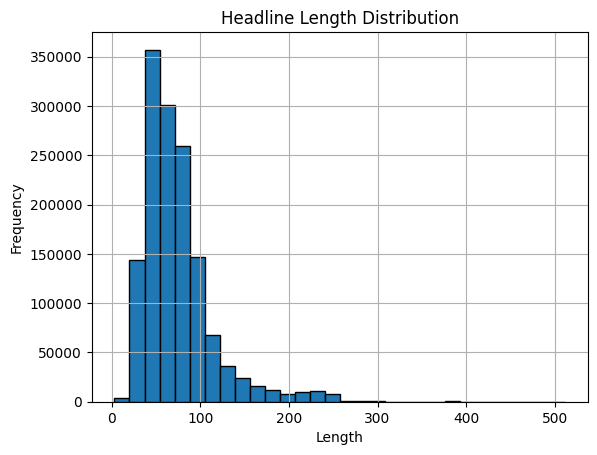

In [135]:

data['headline_length'].hist(bins=30, edgecolor='black')
plt.title('Headline Length Distribution')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()


In [136]:

# Check if the 'publisher' column exists
if 'publisher' in data.columns:
    # Count the number of articles per publisher
    publisher_counts = data['publisher'].value_counts()

    # Display the counts
    print(publisher_counts)

    # Optionally save to a CSV file
    publisher_counts.to_csv('publisher_counts.csv', header=['Article_Count'])
else:
    print("Column 'publisher' not found in dataset.")


publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
                      ...  
MoneyGeek                 1
muathe                    1
Robert Morris             1
LeftCoastHedgie           1
Jeremie Capron            1
Name: count, Length: 1034, dtype: int64


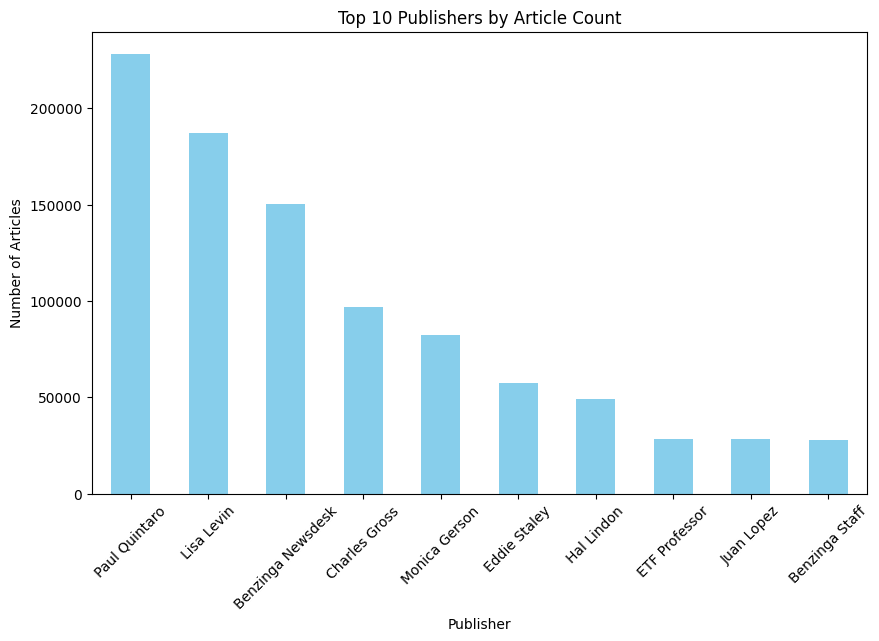

In [137]:

# Plot the top 10 publishers by article count
publisher_counts.head(10).plot(kind='bar', color='skyblue', figsize=(10, 6))
plt.title('Top 10 Publishers by Article Count')
plt.xlabel('Publisher')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.show()


Found 1351341 rows with invalid dates.


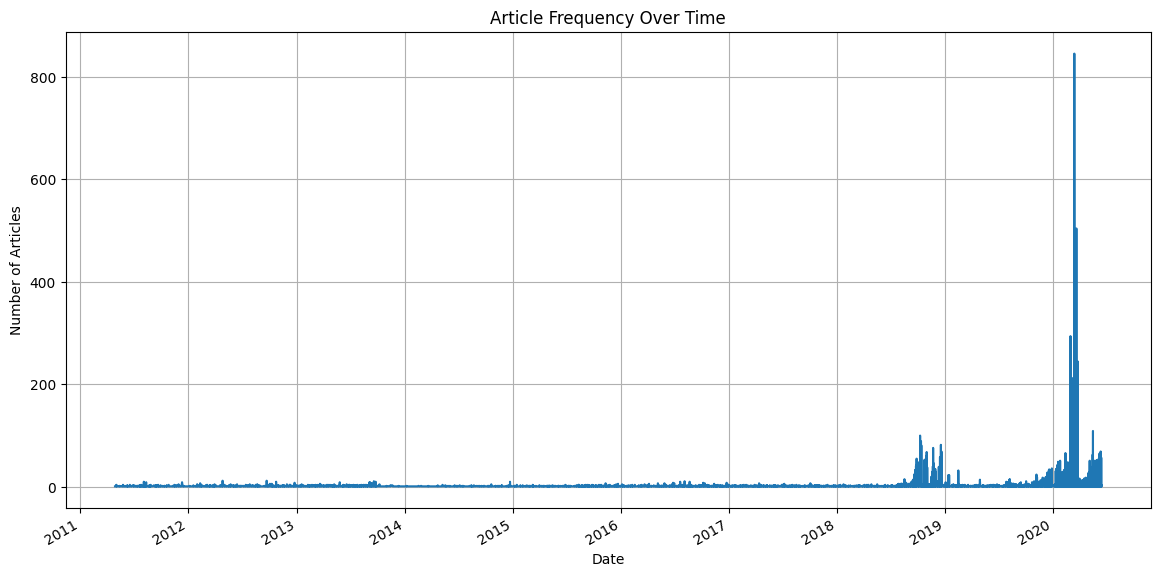

In [138]:

# Convert the 'date' column to datetime format
data['date'] = pd.to_datetime(data['date'], errors='coerce')

# Check for invalid dates
if data['date'].isnull().sum() > 0:
    print(f"Found {data['date'].isnull().sum()} rows with invalid dates.")
    data = data.dropna(subset=['date'])
# Count articles published each day
daily_counts = data['date'].value_counts().sort_index()

# Plot daily trends
plt.figure(figsize=(14, 7))
daily_counts.plot()
plt.title('Article Frequency Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.grid()
plt.show()


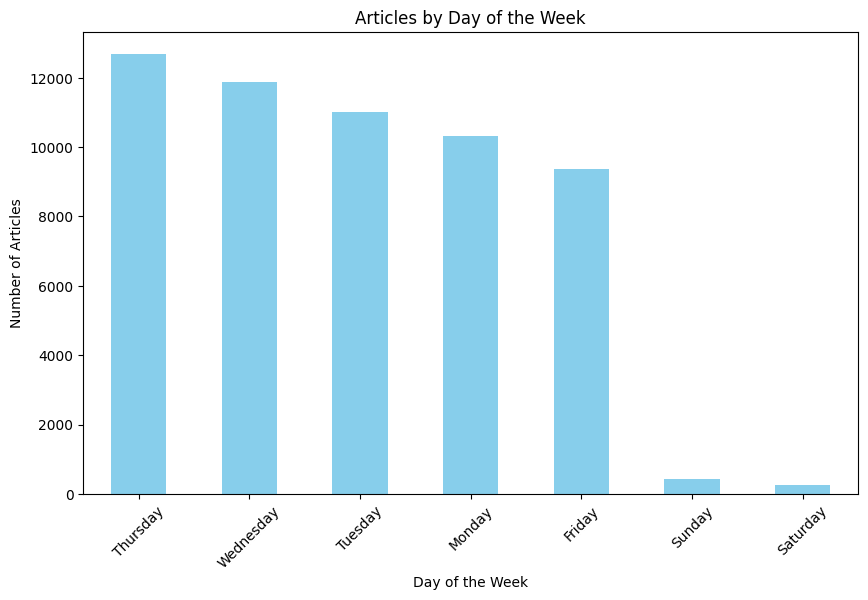

In [139]:
# Extract day of the week
data['day_of_week'] = data['date'].dt.day_name()

# Count articles by day of the week
day_of_week_counts = data['day_of_week'].value_counts()

# Plot the results
day_of_week_counts.plot(kind='bar', color='skyblue', figsize=(10, 6))
plt.title('Articles by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.show()


C:\Users\Hasan\AppData\Local\Temp\ipykernel_13076\1506670494.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  monthly_counts = data.groupby(data['date'].dt.to_period('M')).size()


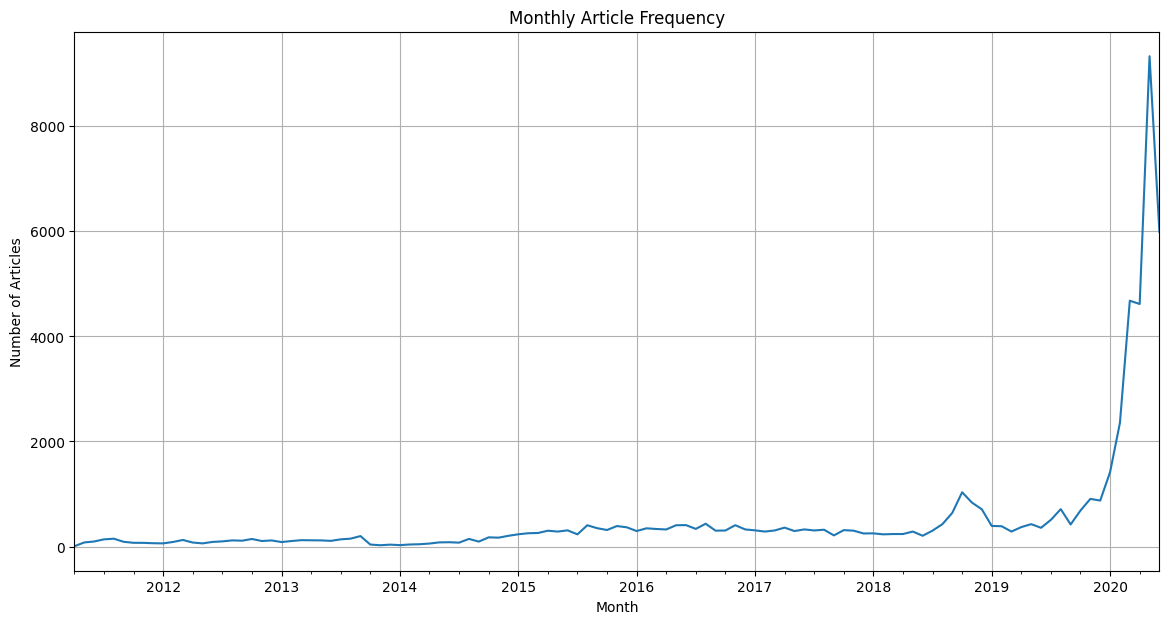

In [140]:
# Articles per month
monthly_counts = data.groupby(data['date'].dt.to_period('M')).size()

# Plot monthly trends
monthly_counts.plot(kind='line', figsize=(14, 7))
plt.title('Monthly Article Frequency')
plt.xlabel('Month')
plt.ylabel('Number of Articles')
plt.grid()
plt.show()

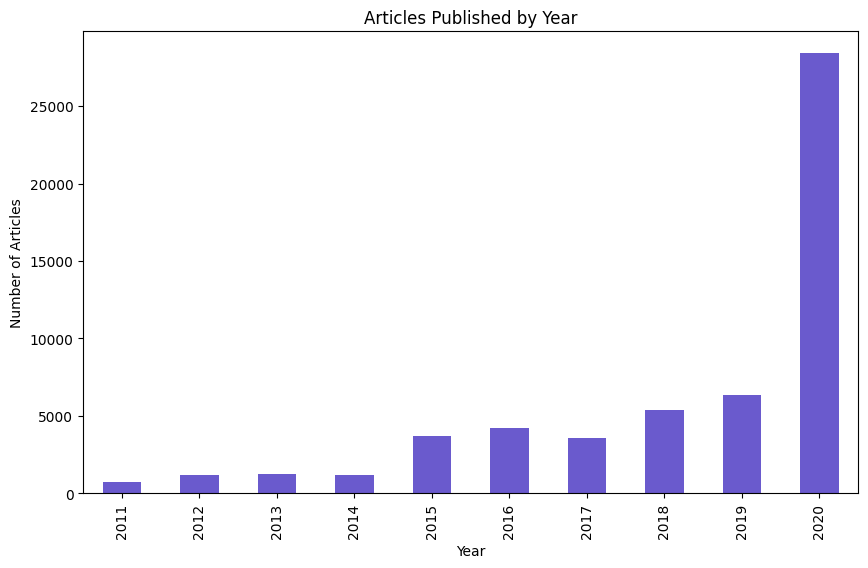

In [141]:
# Extract year 
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month

# Articles per year
yearly_counts = data['year'].value_counts().sort_index()

# Plot yearly trends
yearly_counts.plot(kind='bar', color='SlateBlue', figsize=(10, 6))
plt.title('Articles Published by Year')
plt.xlabel('Year')
plt.ylabel('Number of Articles')
plt.show()

Number of articles during the event: 7646


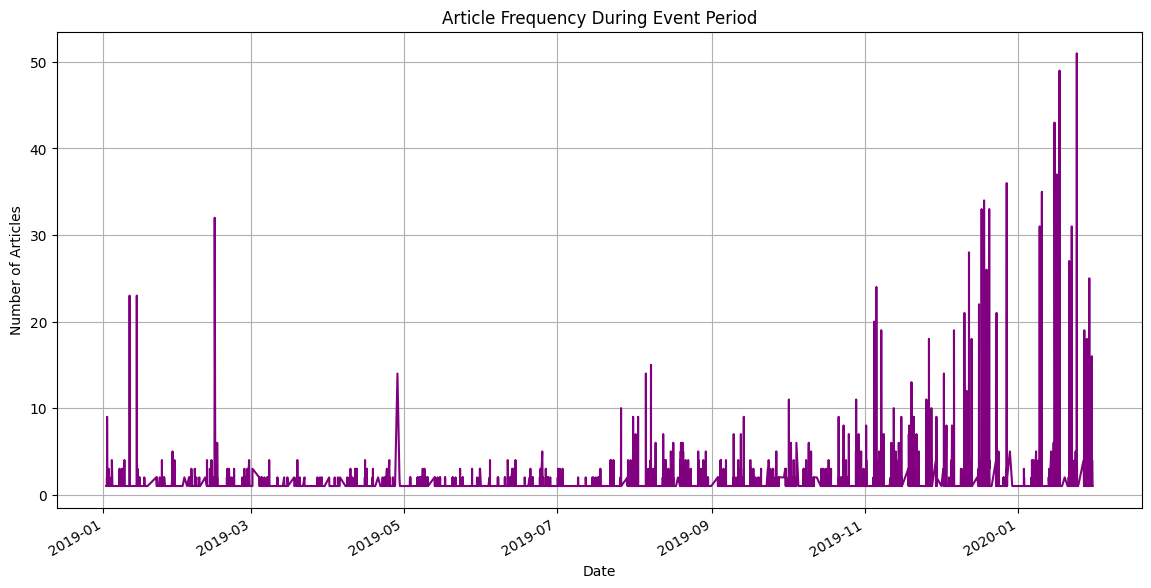

In [142]:
# Compare the Article during the specific events to filter for a specific time period
event_period = (data['date'] >= '2019-01-01') & (data['date'] <= '2020-01-31')
event_articles = data[event_period]

# Count articles during the event period
print(f"Number of articles during the event: {event_articles.shape[0]}")

# Daily trend during the event period
event_daily_counts = event_articles['date'].value_counts().sort_index()

# Plot
event_daily_counts.plot(kind='line', figsize=(14, 7), color='purple')
plt.title('Article Frequency During Event Period')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.grid()
plt.show()


In [143]:

#Using TextBlob for Sentiment Analysis
# Check if 'headline' column exists
if 'headline' in data.columns:
    # Perform sentiment analysis
    def get_sentiment(text):
        analysis = TextBlob(text)
        polarity = analysis.sentiment.polarity  # Polarity ranges from -1 (negative) to +1 (positive)
        if polarity > 0:
            return 'Positive'
        elif polarity < 0:
            return 'Negative'
        else:
            return 'Neutral'

    # Apply the sentiment function to the headlines
    data['sentiment'] = data['headline'].astype(str).apply(get_sentiment)

    # Display results
    print(data[['headline', 'sentiment']].head())

    # Save results to a new CSV
    data.to_csv('headlines_with_sentiment.csv', index=False)
else:
    print("Column 'headline' not found in dataset.")


                                            headline sentiment
0            Stocks That Hit 52-Week Highs On Friday   Neutral
1         Stocks That Hit 52-Week Highs On Wednesday   Neutral
2                      71 Biggest Movers From Friday   Neutral
3       46 Stocks Moving In Friday's Mid-Day Session   Neutral
4  B of A Securities Maintains Neutral on Agilent...   Neutral


In [144]:
#Using VADER Sentiment Analyzer
# Download the VADER lexicon
nltk.download('vader_lexicon')

# Perform sentiment analysis
if 'headline' in data.columns:
    sia = SentimentIntensityAnalyzer()

    def get_vader_sentiment(text):
        score = sia.polarity_scores(text)
        if score['compound'] > 0.05:
            return 'Positive'
        elif score['compound'] < -0.05:
            return 'Negative'
        else:
            return 'Neutral'

    # Apply VADER sentiment analysis
    data['sentiment'] = data['headline'].astype(str).apply(get_vader_sentiment)

    # Display results
    print(data[['headline', 'sentiment']].head())

    # Save results
    data.to_csv('headlines_with_sentiment.csv', index=False)
else:
    print("Column 'headline' not found in dataset.")


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Hasan\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


                                            headline sentiment
0            Stocks That Hit 52-Week Highs On Friday   Neutral
1         Stocks That Hit 52-Week Highs On Wednesday   Neutral
2                      71 Biggest Movers From Friday   Neutral
3       46 Stocks Moving In Friday's Mid-Day Session   Neutral
4  B of A Securities Maintains Neutral on Agilent...  Positive


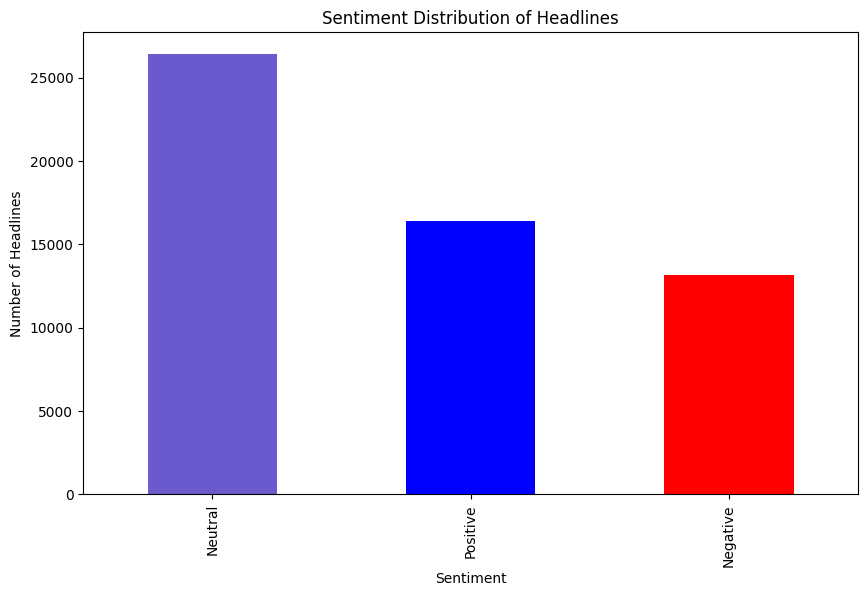

In [145]:

#. Visualize Sentiment Distribution

# Count the sentiment labels
sentiment_counts = data['sentiment'].value_counts()

# Plot
sentiment_counts.plot(kind='bar', color=['SlateBlue', 'blue', 'red'], figsize=(10, 6))
plt.title('Sentiment Distribution of Headlines')
plt.xlabel('Sentiment')
plt.ylabel('Number of Headlines')
plt.show()


In [146]:
if 'headline' not in data.columns:
    raise ValueError("The dataset must have a 'headline' column.")

# Extract relevant columns
headlines = data['headline'].dropna().tolist()

# Step 2: Initialize the NLP model
nlp = spacy.load("en_core_web_sm")

# Function to process text for keywords and entities
def extract_keywords_and_entities(texts):
    keywords = []
    entities = []
    for doc in texts:
        processed = nlp(doc)
        # Extract keywords (lemmatized, filtered)
        keywords.extend([token.lemma_ for token in processed if not token.is_stop and token.is_alpha])
        # Extract named entities
        entities.extend([ent.text for ent in processed.ents])
    return keywords, entities
# Step 3: Extract keywords and entities from headlines
keywords, entities = extract_keywords_and_entities(headlines)

# Step 4: TF-IDF for keyphrase extraction
tfidf = TfidfVectorizer(max_features=20, ngram_range=(1, 2))  # Adjust max_features if needed
tfidf_matrix = tfidf.fit_transform(headlines)
top_phrases = tfidf.get_feature_names_out()

# Step 5: Summarize results
top_keywords = Counter(keywords).most_common(10)
top_entities = Counter(entities).most_common(10)

print("Top Keywords:", top_keywords)
print("Top Entities:", top_entities)
print("Top Phrases (TF-IDF):", top_phrases)

Top Keywords: [('stock', 12373), ('week', 8987), ('share', 8406), ('trade', 6323), ('hit', 6116), ('m', 5905), ('company', 5593), ('EPS', 5527), ('market', 4514), ('Price', 4502)]
Top Entities: [('52-Week', 4659), ('52-Week Lows', 3566), ('Thursday', 2871), ('US', 2768), ('Friday', 2314), ('EPS', 2159), ('Yesterday', 1996), ('Wednesday', 1880), ('Monday', 1566), ('Tuesday', 1527)]
Top Phrases (TF-IDF): ['52' '52 week' 'and' 'are' 'for' 'from' 'hit' 'hit 52' 'in' 'of' 'on'
 'shares' 'stocks' 'stocks that' 'that' 'that hit' 'the' 'to' 'trading'
 'week']


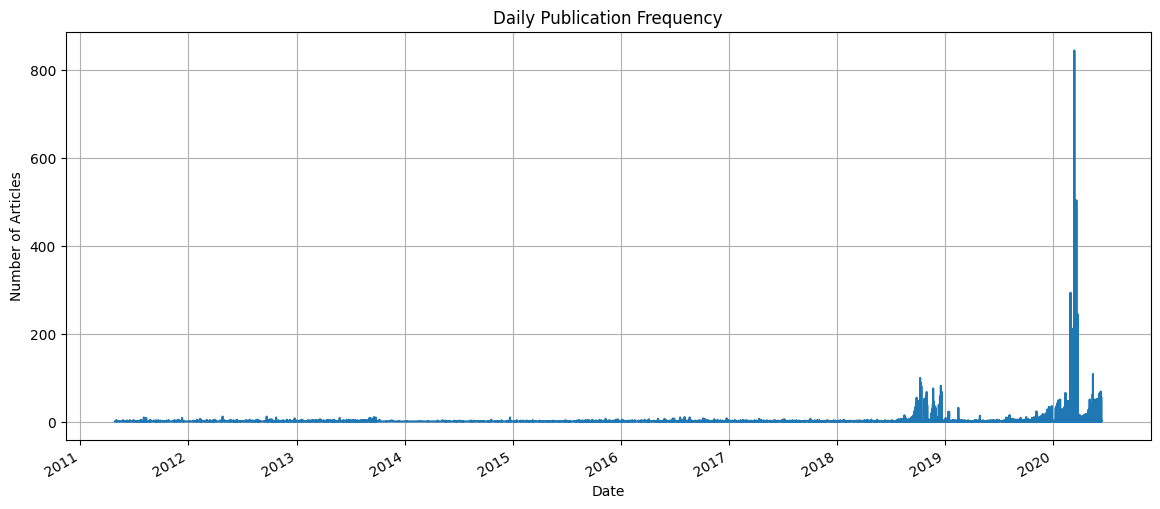

In [147]:


# Convert the 'date' column to datetime format
data['date'] = pd.to_datetime(data['date'])

# Extract only the 'date' and 'headline' columns for simplicity
data = data[['date', 'headline']].dropna()

# Group by date and count the number of articles per day
daily_counts = data.groupby('date').size()
#Create a time-series plot to visualize trends in publication frequency.
# Step 2: Plot daily publication counts
plt.figure(figsize=(14, 6))
daily_counts.plot()
plt.title("Daily Publication Frequency")
plt.xlabel("Date")
plt.ylabel("Number of Articles")
plt.grid()
plt.show()

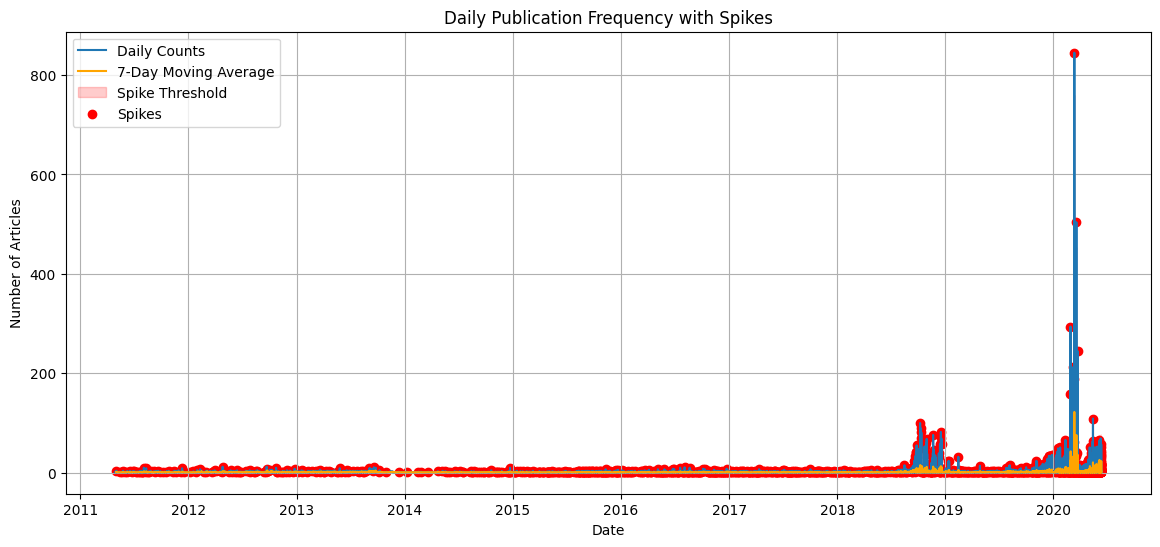

In [148]:
# Calculate rolling mean and standard deviation
rolling_mean = daily_counts.rolling(window=7).mean()  # 7-day moving average
rolling_std = daily_counts.rolling(window=7).std()

# Define a threshold for spikes (e.g., 2 standard deviations above the rolling mean)
threshold = rolling_mean + 2 * rolling_std
spikes = daily_counts[daily_counts > threshold]

# Plot with spikes highlighted
plt.figure(figsize=(14, 6))
plt.plot(daily_counts, label="Daily Counts")
plt.plot(rolling_mean, label="7-Day Moving Average", color="orange")
plt.fill_between(threshold.index, threshold, color="red", alpha=0.2, label="Spike Threshold")
plt.scatter(spikes.index, spikes, color="red", label="Spikes")
plt.title("Daily Publication Frequency with Spikes")
plt.xlabel("Date")
plt.ylabel("Number of Articles")
plt.legend()
plt.grid()
plt.show()


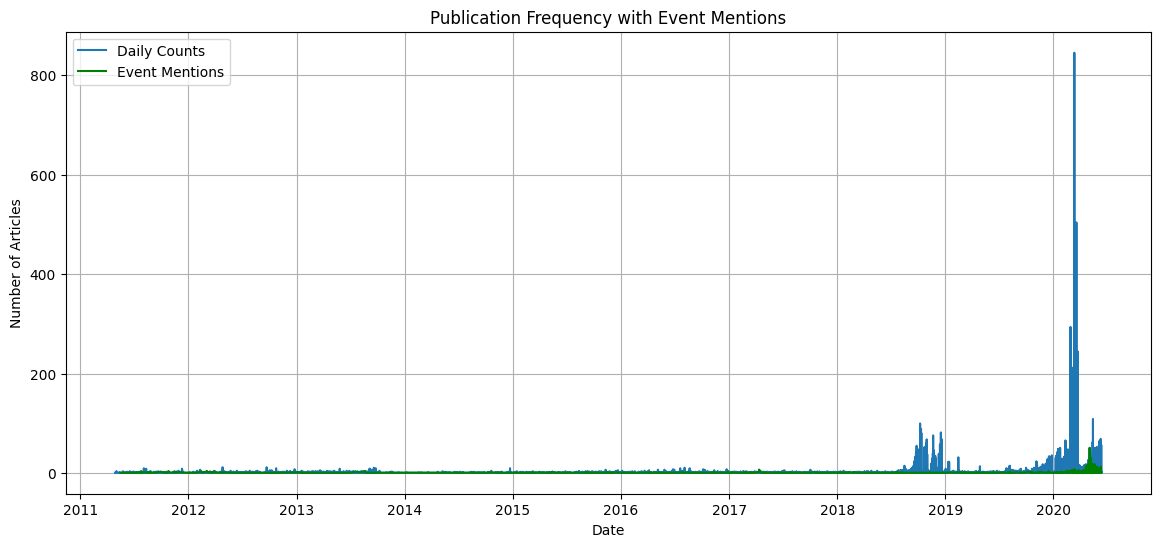

In [149]:
#Correlate Spikes with Market Events
keywords = ["interest rate", "earnings", "FDA approval"]
filtered_data = data[data['headline'].str.contains('|'.join(keywords), case=False, na=False)]

# Group filtered data by date
event_counts = filtered_data.groupby('date').size()

# Overlay event counts on the original plot
plt.figure(figsize=(14, 6))
plt.plot(daily_counts, label="Daily Counts")
plt.plot(event_counts, label="Event Mentions", color="green")
plt.title("Publication Frequency with Event Mentions")
plt.xlabel("Date")
plt.ylabel("Number of Articles")
plt.legend()
plt.grid()
plt.show()


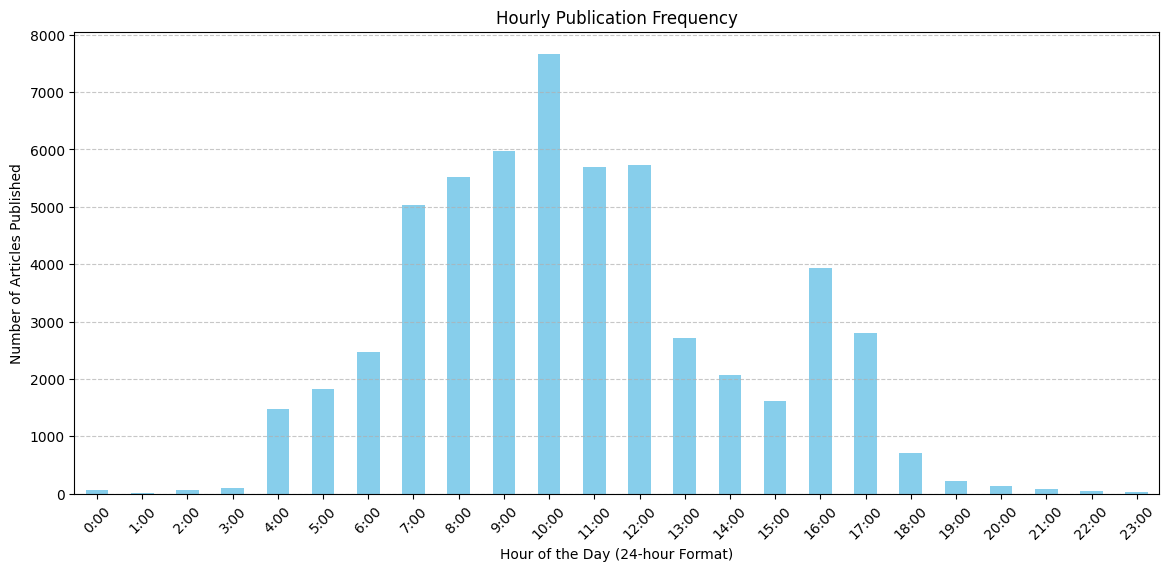

In [150]:
# Convert 'date' or 'timestamp' to datetime
data['timestamp'] = pd.to_datetime(data['date'])  # Assuming the 'date' column has full timestamps

# Extract the hour of publication
data['hour'] = data['timestamp'].dt.hour
# Count the number of articles published per hour
hourly_counts = data.groupby('hour').size()

# Plot hourly publication frequency
plt.figure(figsize=(14, 6))
hourly_counts.plot(kind='bar', color='skyblue')
plt.title("Hourly Publication Frequency")
plt.xlabel("Hour of the Day (24-hour Format)")
plt.ylabel("Number of Articles Published")
plt.xticks(range(0, 24), labels=[f"{h}:00" for h in range(24)], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

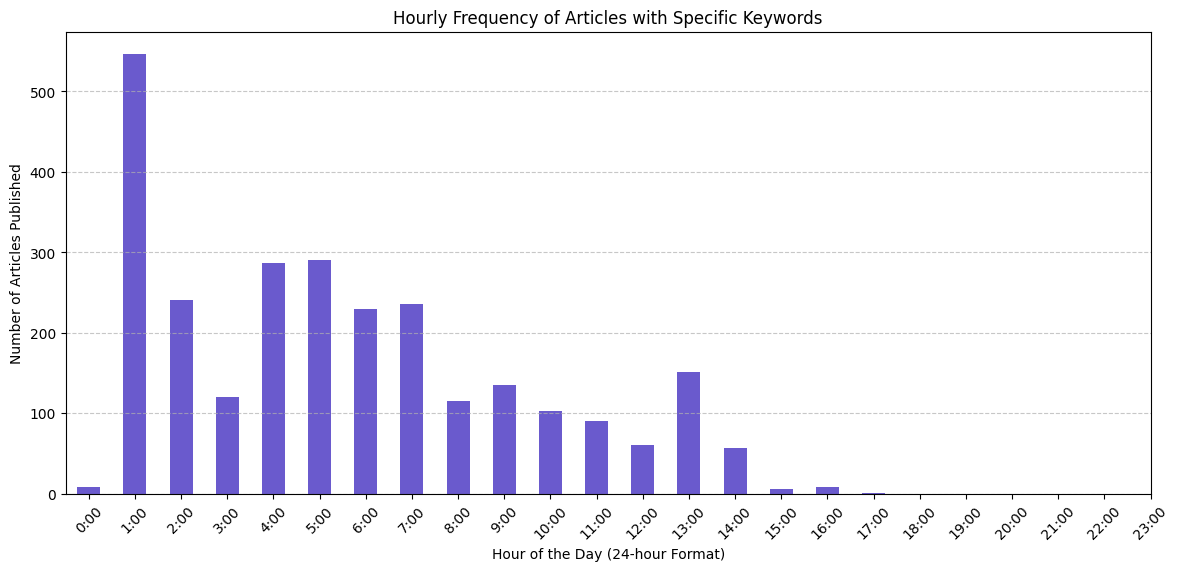

In [151]:
#Correlate Times with Market Events
keywords = ['earnings', 'guidance', 'announcement']
filtered_data = data[data['headline'].str.contains('|'.join(keywords), case=False, na=False)]
filtered_hourly_counts = filtered_data.groupby('hour').size()

# Plot filtered publication frequency
plt.figure(figsize=(14, 6))
filtered_hourly_counts.plot(kind='bar', color='SlateBlue')
plt.title("Hourly Frequency of Articles with Specific Keywords")
plt.xlabel("Hour of the Day (24-hour Format)")
plt.ylabel("Number of Articles Published")
plt.xticks(range(0, 24), labels=[f"{h}:00" for h in range(24)], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


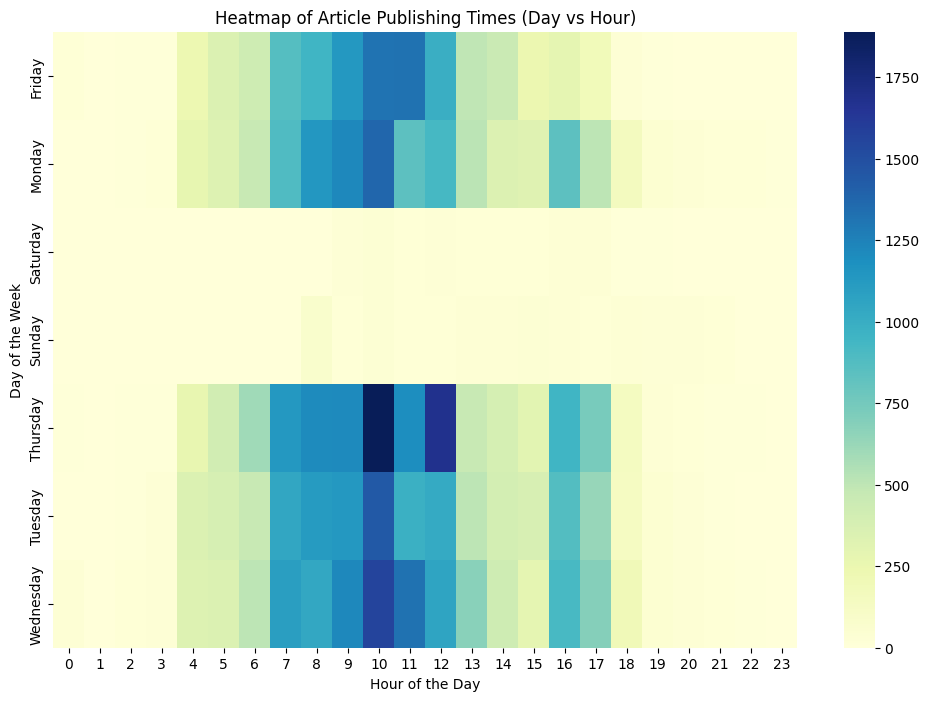

In [152]:
#Heatmap of Publishing Times by Day
data['day'] = data['timestamp'].dt.day_name()
hourly_day_counts = data.groupby(['day', 'hour']).size().unstack().fillna(0)

# Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(hourly_day_counts, cmap="YlGnBu", annot=False)
plt.title("Heatmap of Article Publishing Times (Day vs Hour)")
plt.xlabel("Hour of the Day")
plt.ylabel("Day of the Week")
plt.show()
